In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [100]:
class OptimLine():

  def __init__(self,z1, y1, dict_var, n_bins, vbase = 500, sbase = 100):

    self.z1                   = z1
    self.y1                   = y1
    self.gama                 = np.sqrt(z1*y1) #1/km
    self.n_bins               = n_bins
    self.dict_var             = dict_var
    self.vbase                = vbase #kV
    self.sbase                = sbase #MW
    self._history             = None
    
    self.loop()

  def decode_bin(self,key,n):
    """ Turn variable bin into its real value."""
    v_min, v_max = self.dict_var[key]
    
    if 0 < n <= self.n_bins:    
      return (v_max - v_min)*(n-1)/(self.n_bins-1) + v_min
    else: raise IndexError('Bin out of index') 
    
  def one_bit_shift(self, a):

    size = a.shape[0]

    if a.all() != 1:
      
      if a[0] != 1:
        a = np.roll(a,-1)
      else:
        a = a[-2::-1]

      return np.concatenate([a,np.ones(size - a.shape[0], dtype = int)])

    return np.concatenate([np.zeros(size - 1, dtype = int),np.array([1])])

  def history(self, current_state, Loss = 0, up_theta = False):

    if not up_theta:
      values = np.array([self.decode_bin(list(self.dict_var.keys())[idx],state) for idx, state in enumerate(current_state)])
      max = np.array([self.decode_bin(key,self.n_bins) for key in list(self.dict_var.keys())])
      min = np.array([self.decode_bin(key,1) for key in list(self.dict_var.keys())])
      norm = (values - min)/(max - min)
      if self._history is None:
        self._history = np.concatenate([norm,[1 - Loss]])
      
      else: 
        aux = np.concatenate([norm,[1 - Loss]])
        self._history = np.vstack([self._history, aux])

    else: #para atualizar com theta
      idx = list(self.dict_var.keys()).index('theta')
      self._history = np.vstack([self._history,self._history[-1]])
      value_2 = self.decode_bin('theta', current_state[-1]) 
      value_1 = self.decode_bin('theta', current_state[0])
      max = self.decode_bin('theta', self.n_bins)
      min = self.decode_bin('theta', 1)
      aux = (value_2 - value_1)/(max - min)
      self._history[-1][idx] = aux

  def loop(self, start_state = True):
    
    idx = list(self.dict_var.keys()).index('theta')

    if start_state:
       start_state = self.n_bins*np.ones(len(self.dict_var))
       start_state[idx] =  int(self.n_bins/2)

    current_state = start_state[:]

    # Find max common layer for all variables
    out, perc_Loss = self.compute(current_state)
    self.history(current_state, perc_Loss)

    disc = np.ones(len(self.dict_var))
    disc[idx] =  0
    
    while not out:
      current_state = current_state - disc
      out, perc_Loss = self.compute(current_state)
      self.history(current_state, perc_Loss)

    # Increasing bins gradually, but theta
    
    #disc[list(self.dict_var.keys()).index('theta')] =  0
    
    base_state = current_state[:]
    disc = disc*0
    disc[-1] = 1
    copy_disc = np.copy(disc)
    copy_disc[idx] =  0
    best_state = 0*current_state

    while True:  
      current_state = base_state + copy_disc
      current_state[current_state > self.n_bins] = self.n_bins
      out, perc_Loss = self.compute(current_state)

      # se resultado for positivo, salva estado e continua as combinacoes
      if out:
        self.history(current_state, perc_Loss)
        best_state = current_state[:]

      # se chegou no final e tem um estado melhor que a base, substitui a base por esse maximo e roda novas combinacoes
      if (disc == 1).all():
        if (best_state == base_state).all():
          break
        else:
          base_state = best_state[:]          
          best_state = 0*best_state

      disc = self.one_bit_shift(disc)
      copy_disc = np.copy(disc)
      copy_disc[idx] =  0
      #current_state = base_state + copy_disc
    
    # Excursionando theta
    current_state = best_state[:]
    list_val_theta = []
    for bin in range(1, self.n_bins + 1):
      current_state[idx] = bin
      out, perc_Loss = self.compute(current_state)
      
      if out: # and (best_state != base_state).all():
        list_val_theta.append(bin)
        #rint(list_val_theta)
        self.history(np.array(list_val_theta), up_theta = True)

    #best_state[]

  def compute(self, current_state):
    """ Verify whether the current state variables provide the Line a good operation point."""
    
    def calc_param(Zc,a,b,c,Vr,theta,pout=0):      

      Pn = (Vr)**2/np.real(Zc) #MW Total
      #Teste com carga nominal ou sobrecarga
      if pout != 0:
        Pout = Pn*pout #MW
        
        Vrp = Vr/np.sqrt(3)
        Ir = np.conjugate((Pout + 1j*Pout*np.tan(theta*np.pi/180))/(np.sqrt(3)*Vr)) #kA
        V, Is = np.array([[a,b],[c,a]])@np.array([Vrp,Ir]) #kV,kA
        Loss = 3*(np.real(V*np.conjugate(Is)) - np.real(Vrp*np.conjugate(Ir))) #MW ver aqui
                  
      #Teste de efeito Ferranti (não utilizado por enquanto)
      else:
        V = 1*self.vbase/a #kV
        Is = V*c #kA
        Loss = 3*(np.real(1*self.vbase*np.conjugate(Is)/np.sqrt(3))) #MW
      
      if not(self.dict_var['vr'][0] <= abs(np.sqrt(3)*V/self.vbase) <= self.dict_var['vr'][1]) or abs(np.angle(V, deg = True)) > 30 or Loss > Pn:
          return False, (Loss/Pn) #(Loss/(3*np.real(V*np.conjugate(Is))))
      return True, (Loss/Pn) #(Loss/(3*np.real(V*np.conjugate(Is))))

    values = [self.decode_bin(list(self.dict_var.keys())[idx],state) for idx, state in enumerate(current_state)]
    L = values[0] #km
    Zc = np.sqrt(self.z1/self.y1) #Ohm
    a = np.cosh(self.gama*L) #1
    b = Zc*np.sinh(self.gama*L) #Ohm
    c = (1/Zc)*np.sinh(self.gama*L) #Mho
    theta = values[1] #degree
    Vr = values[2]*self.vbase #kV Linha
    sn = values[3] #pu

    # Teste com carga nominal
    Teste1, perc_Loss = calc_param(Zc,a,b,c,Vr,theta,pout=sn)

    # Teste de efeito Ferranti
    #Teste2 = calc_param(Zc,a,b,c,Vr,theta,pout=0)
    
    
    return Teste1, perc_Loss #*Teste2

  def area(self, array_modules):

    ang_inc = 2*np.pi/array_modules.shape[0]
    array_angles = np.arange(np.pi/2, 5*np.pi/2 + ang_inc, ang_inc)[:-1]
        
    array_coord = np.array([[mod*np.cos(array_angles[idx]),mod*np.sin(array_angles[idx])] for idx, mod in enumerate(array_modules)])
    array_coord = np.vstack([array_coord, array_coord[0]])
    
    area = 0.5*np.sum(np.abs([np.linalg.det(array_coord[line:line+2]) for line in range(array_coord.shape[0] - 1)]))
    
    return area, array_coord[:-1]

  def plot(self, points, **kwg):
    
    
    if 'keys' in kwg:
        dict_keys = {'L(km)': 'L',
                     'theta': '$\Delta\\theta$',
                     'vr': '$V_r$',
                     'Sn': '$S_n$'}
        labels = kwg['keys']
        labels = [dict_keys[key] for key in list(dict_keys.keys())]
        labels.append('Loss')
    else:
        labels = points.shape[0]*['']
    if 'output_path' in kwg:
        output = kwg['output_path']
    else:
        output = ''
    
    if 'area' in kwg:
        area = kwg['area']
    else:
        area = ''
    
    if 'title' in kwg:
        title = kwg['title']
    else:
        title = 'Linha de transmissao'
        
    if 'dpi' in kwg:
        dpi = kwg['title']
    else:
        dpi = 200
    
    fig, ax = plt.subplots(dpi = dpi)
    
    # Plotar esqueleto
    n_points = points.shape[0]
    array_mod = np.linspace(0,1,5)[1:]
    array_angle =  np.arange(np.pi/2, 5*np.pi/2 + 2*np.pi/n_points, 2*np.pi/n_points)
    array_layers =  np.array([ [[mod*np.cos(angle), mod*np.sin(angle)] for angle in array_angle] for mod in np.linspace(0,1,5)[1:] ])
    [ax.plot(layer[:,0], layer[:,1], ':k', alpha = 0.5) for layer in array_layers]
    
    # Plotting Polygon
    [ax.plot([0,layer1[0]],[0,layer1[1]], '-k', alpha = 0.5, linewidth = 0.5) for layer1 in array_layers[-1]]
    plt.gca().add_patch(patches.Polygon(points, alpha = 0.5, lw = 1.5, ls = '-', edgecolor = 'k', facecolor = 'purple'))

    # Adjusting text
    [ax.text(layer1[0]*(1 + 0.08/abs(layer1[0])), layer1[1]*(1 + 0.05/abs(layer1[1])), labels[idx],fontweight = 'medium', fontsize = 12) for idx, layer1 in enumerate(array_layers[-1][:-1])]
    ax.text(0.50, 0.85, 'Area: %.4f'%(area) , fontfamily = 'serif', fontweight = 'bold', fontsize = 12)
    ax.axis(False)
    plt.title(title, fontsize = 'xx-large', fontweight = 'bold', pad = 20)
    
    plt.show()
    
    


In [101]:
variables = {'L(km)': [80,300],
             'theta': [-30,30],             
             'vr': [0.95,1.05],
             'Sn': [0.1,4]
             }

# keep non-simmetrical variables on the bottom

n_bins = 50

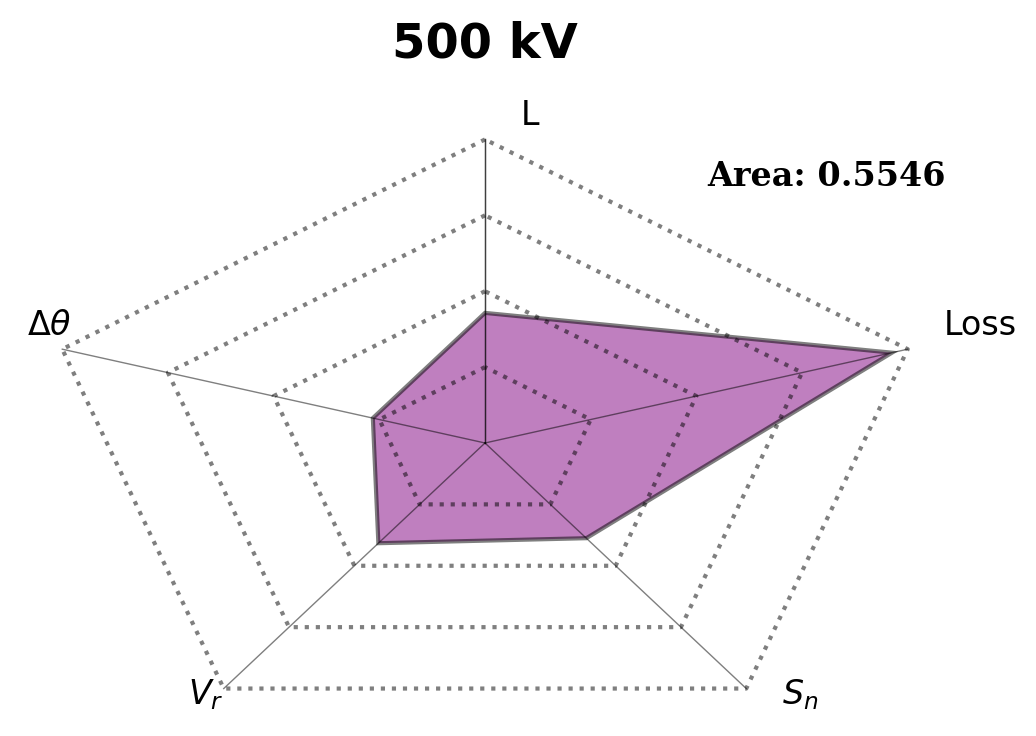

In [102]:
# 500 kV
z1 = 0.022190408640634214 + 1j*0.34665038554475636
y1 = 1j*4.845131194232457e-6
Line1 = OptimLine(z1,y1,variables,n_bins)
area, coord = Line1.area(Line1._history[-1])
keys = list(Line1.dict_var.keys())
Line1.plot(coord, area = area, keys = keys, title = '500 kV')


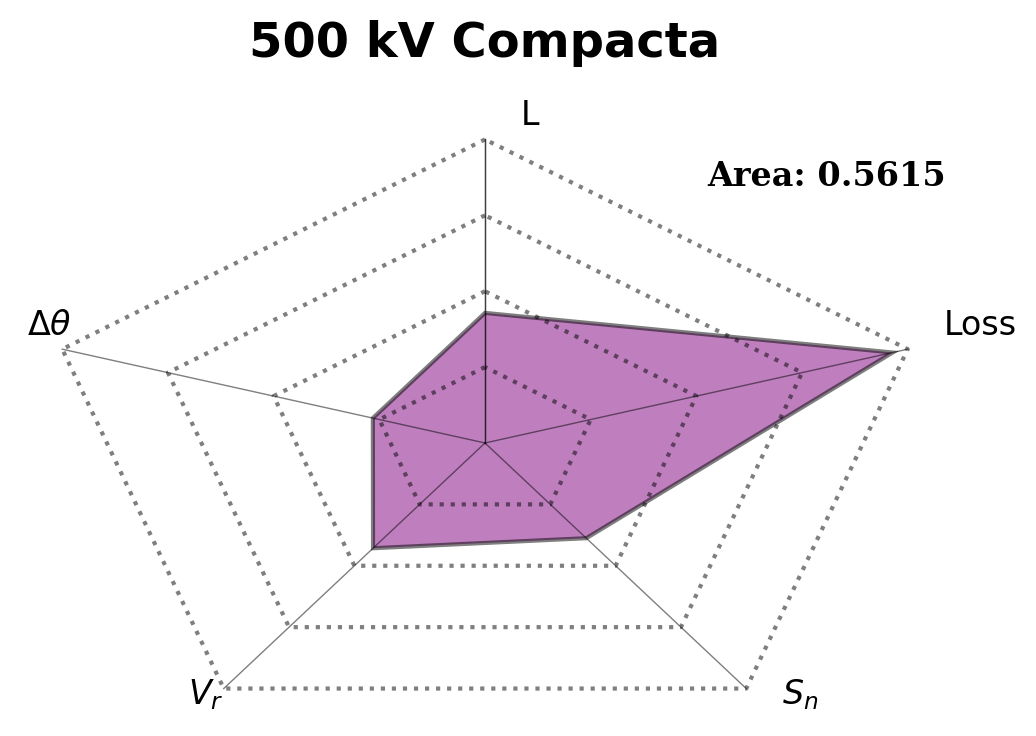

In [103]:
# 500 kV compacta
z2 = 0.016627313705499122 + 0.2676290633843461*1j;
y2 = 1j*6.0975547780729794e-6;
Line2 = OptimLine(z2,y2,variables,n_bins)
area, coord = Line2.area(Line2._history[-1])
keys = list(Line2.dict_var.keys())
Line2.plot(coord, area = area, keys = keys, title = '500 kV Compacta')

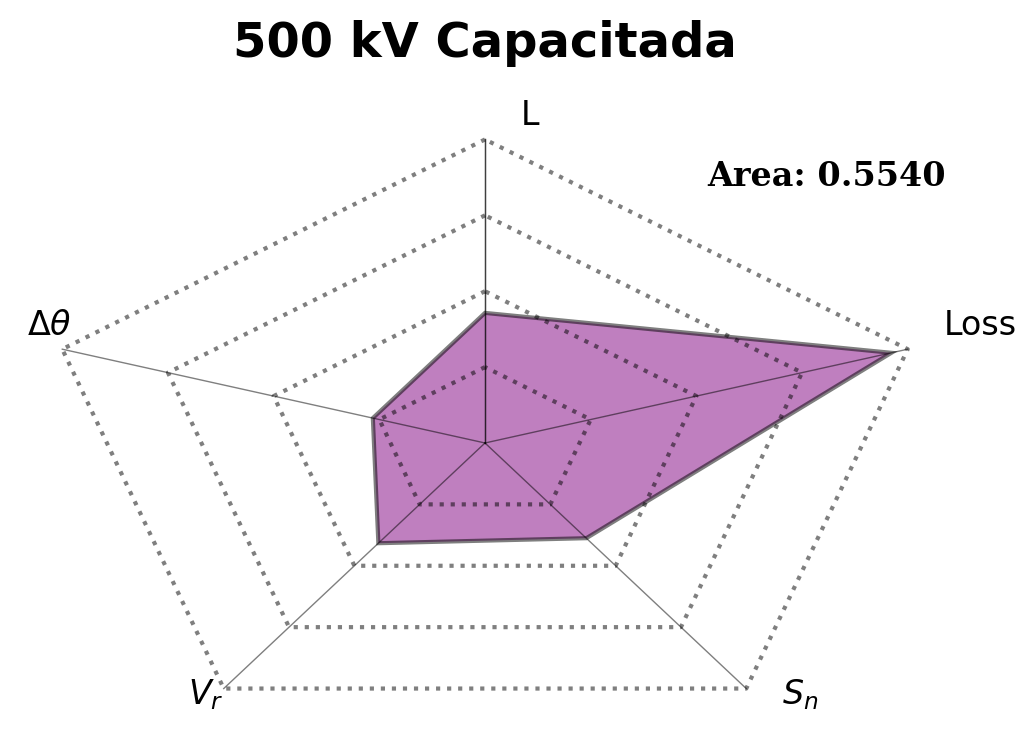

In [104]:
# 500 kV capacitada
z3 = 0.016631216371080317 + 0.2499488173319771*1j
y3 = 1j*6.7068614020792455e-6
Line3 = OptimLine(z3,y3,variables,n_bins)
area, coord = Line3.area(Line3._history[-1])
keys = list(Line3.dict_var.keys())
Line3.plot(coord, area = area, keys = keys, title = '500 kV Capacitada')

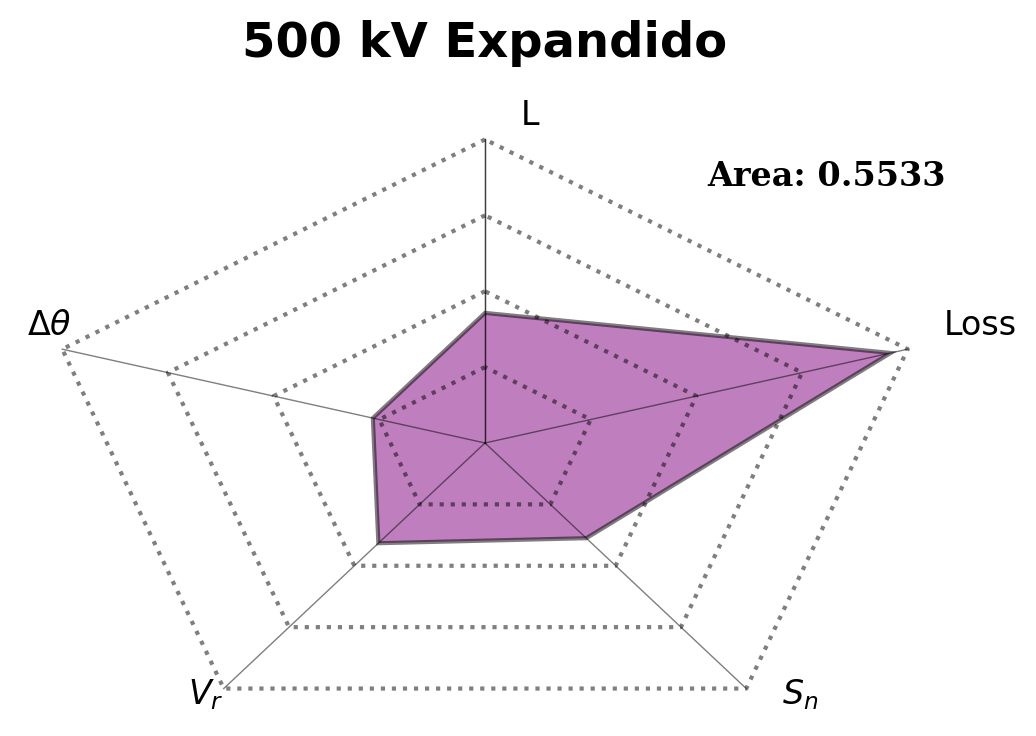

In [105]:
# 500 kV expandido
z4 = 0.01349074087148576 + 0.19432017869484816*1j
y4 = 3.0000000000000136e-9 + 1j*8.604206875650306e-6;
Line4 = OptimLine(z4,y4,variables,n_bins)
Line4.loop()
area, coord = Line4.area(Line4._history[-1])
keys = list(Line4.dict_var.keys())
Line4.plot(coord, area = area, keys = keys, title = '500 kV Expandido')

In [106]:
Line2._history[-1]


array([0.42857143, 0.26530612, 0.42857143, 0.3877551 , 0.96436526])

In [107]:
abs(2+3j)*(3**.5)

6.244997998398397

In [108]:
abs((2+3j)*(3**.5))

6.244997998398398